# Lesson 2: Convolutional Neural Networks with PyTorch
- [@AlfredoCanziani](https://twitter.com/alfredocanziani)
- [@GokuMohandas](https://twitter.com/GokuMohandas)

In [7]:
import os
import sys
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl

from pycrayon import (
    CrayonClient,
)

from IPython import (
    display,
)

from IPython.display import (
    Image,
    clear_output,
)

# get matplotlib configuration
%matplotlib inline
%run plot_conf.py

In [8]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import (
    Variable,
)

from torch.nn import (
    init,
)

from torchvision import (
    datasets, 
    transforms,
    models,
    utils,
)

### Simple CNN for MNIST Classification

In [9]:
# training params
batch_size = 64
num_epochs = 3
learning_rate = 0.01
dropout_p = 0.5
log_interval = 1 # epochs
num_hidden_units = 50
num_classes = 10 # MNIST
decay_rate = 0.9999
max_grad_norm = 5.0

# Use gpu
cuda = True
cuda = cuda and torch.cuda.is_available()

# reproduceability
seed = 1234
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

In [10]:
# Train data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

# Test data loader
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/mnist', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

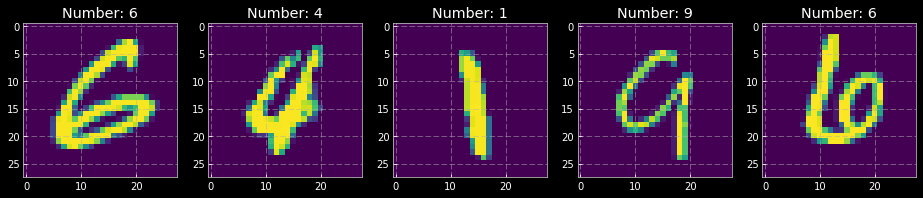

In [11]:
# Visualize some samples
for batch in test_loader:
    samples = batch[0][:5]
    y_true = batch[1]
    plt.subplot(1, 5, 1)
    for i, sample in enumerate(samples):
        plt.subplot(1, 5, i+1)
        plt.title('Number: %i'% y_true[i])
        plt.imshow(sample.numpy().reshape((28,28)))
    break

In [12]:
# CNN model
class CNN(nn.Module):
    """
    Simple CNN for MNIST classification.
    """
    def __init__(self, dropout_p, num_hidden_units, num_classes):
        """
        Initialization.
        """
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout_conv2 = nn.Dropout2d(dropout_p)
        self.fc1 = nn.Linear(320, num_hidden_units)
        self.fc2 = nn.Linear(num_hidden_units, num_classes)

    def forward(self, x):
        """
        Feed Foward.
        """
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.dropout_conv2(self.conv2(x)), 2))
        x = x.view(-1, 320) # flatten
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x # logits

In [13]:
# Initialize model components
model = CNN(dropout_p, num_hidden_units, num_classes)
if cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [14]:
def process_batch(inputs, targets, model, criterion, optimizer, cuda, is_training):
    """
    Process a minibatch for loss and accuracy.
    """
    
    if cuda:
        inputs, target = inputs.cuda(), target.cuda()
    
    # Convert tensors to Variables (for autograd)
    if is_training:
        X_batch = Variable(inputs, requires_grad=False)
    else:
        X_batch = Variable(inputs, volatile=True, requires_grad=False)
    y_batch = Variable(targets.long(), requires_grad=False)

    # Forward pass
    scores = model(X_batch) # logits

    # Loss
    loss = criterion(scores, y_batch)
    
    # Accuracy
    score, predicted = torch.max(scores, 1)
    accuracy = (y_batch.data == predicted.data).sum() / float(len(y_batch))
    
    if is_training:

        # Use autograd to do backprop. This will compute the
        # gradients w.r.t loss for all Variables that have
        # requires_grad=True. So, our w1 and w2 will now have
        # gradient components we can access.
        optimizer.zero_grad()
        loss.backward()
        
        # Clip the gradient norms
        nn.utils.clip_grad_norm(model.parameters(), max_grad_norm)

        # Update params
        optimizer.step()

    return loss, accuracy

In [15]:
def train(model, criterion, optimizer, train_loader, test_loader, 
          num_epochs, batch_size, log_interval, learning_rate,
          dropout_p, decay_rate, max_grad_norm, cuda):
    """
    Training.
    """
    
    # Metrics
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    # Training
    for num_train_epoch in range(num_epochs):

        # Timer
        start = time.time()

        # Decay learning rate
        learning_rate = learning_rate * (decay_rate ** (num_train_epoch // 1.0))
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate

        # Metrics
        train_batch_loss = 0.0
        train_batch_accuracy = 0.0

        for train_batch_num, (inputs, target) in enumerate(train_loader):

            # Get metrics
            model.train()
            loss, accuracy = process_batch(inputs, target, model, criterion, optimizer, cuda, model.training)

            # Add to batch scalars
            train_batch_loss += loss.data[0] / float(len(inputs))
            train_batch_accuracy += accuracy
            
        # Add to global metrics
        train_loss.append(train_batch_loss/float(train_batch_num+1))
        train_acc.append(train_batch_accuracy/float(train_batch_num+1))

        # Testing
        model.eval()
        for num_test_epoch in range(1):

            # Metrics
            test_batch_loss = 0.0
            test_batch_accuracy = 0.0

            for test_batch_num, (inputs, target) in enumerate(test_loader):

                # Get metrics
                model.eval()
                loss, accuracy = \
                    process_batch(inputs, target, model, criterion, optimizer, cuda, model.training)

                # Add to batch scalars
                test_batch_loss += loss.data[0] / float(len(inputs))
                test_batch_accuracy += accuracy

            # Add to global metrics
            test_loss.append(test_batch_loss/float(test_batch_num+1))
            test_acc.append(test_batch_accuracy/float(test_batch_num+1))
                

            verbose_condition = \
                (num_train_epoch == 0) or (num_train_epoch % log_interval == 0) or (num_train_epoch == num_epochs-1)

            # Verbose
            if verbose_condition:

                # Verbose
                time_remain = (time.time() - start) * (num_epochs - (num_train_epoch+1))
                minutes = time_remain // 60
                seconds = time_remain - minutes*60
                print("TIME REMAINING: %im %is" % (minutes, seconds))
                print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f, [TEST LOSS]: %.6f, [TEST ACC]: %.3f" %
                       (num_train_epoch, train_batch_loss/float(train_batch_num+1), 
                        train_batch_accuracy/float(train_batch_num+1), test_batch_loss/float(test_batch_num+1),
                        test_batch_accuracy/float(test_batch_num+1)))
    
    return model

In [16]:
model = train(model, criterion, optimizer, train_loader, test_loader, 
          num_epochs, batch_size, log_interval, learning_rate,
          dropout_p, decay_rate, max_grad_norm, cuda)

TIME REMAINING: 0m 42s
[EPOCH]: 0, [TRAIN LOSS]: 0.009104, [TRAIN ACC]: 0.821, [TEST LOSS]: 0.002643, [TEST ACC]: 0.951
TIME REMAINING: 0m 21s
[EPOCH]: 1, [TRAIN LOSS]: 0.006367, [TRAIN ACC]: 0.879, [TEST LOSS]: 0.001852, [TEST ACC]: 0.966
TIME REMAINING: 0m 0s
[EPOCH]: 2, [TRAIN LOSS]: 0.006046, [TRAIN ACC]: 0.887, [TEST LOSS]: 0.001718, [TEST ACC]: 0.966


In [17]:
def infer(model, inputs):
    """
    Inference.
    """
    if cuda:
        inputs = inputs.cuda()

    # Convert tensors to Variables (for autograd)
    X_batch = Variable(inputs, volatile=True, requires_grad=False)

    # Forward pass
    scores = model(X_batch) # logits

    # Accuracy
    score, predicted = torch.max(scores, 1)

    return predicted

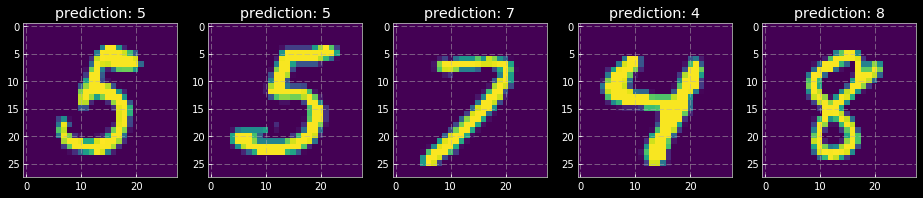

In [18]:
# Visualize some predictions
for batch in test_loader:
    samples = batch[0][:5]
    y_preds = infer(model, samples)
    plt.subplot(1, 5, 1)
    for i, sample in enumerate(samples):
        plt.subplot(1, 5, i+1)
        plt.title('prediction: %i'% y_preds[i].data[0])
        plt.imshow(sample.numpy().reshape((28,28)))
    break

### Torchvision Datasets and Models

- Using popular model architectures.

#### Datasets

In [19]:
# Train data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data/cifar10', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

# Test data loader
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data/cifar10', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [20]:
# Classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 
           'ship', 'truck')

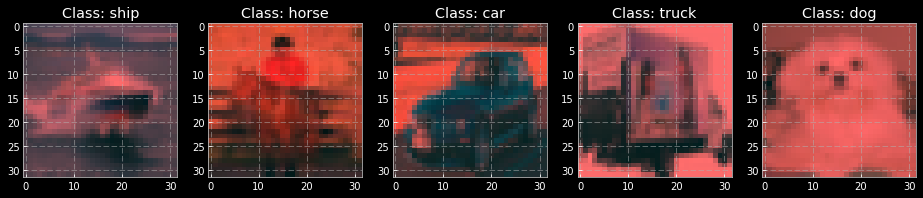

In [21]:
# Visualize some samples
from scipy.misc import toimage
for batch in test_loader:
    samples = batch[0][:5]
    y_true = batch[1]
    plt.subplot(1, 5, 1)
    for i, sample in enumerate(samples):
        plt.subplot(1, 5, i+1)
        plt.title('Class: %s'% classes[y_true[i]])
        plt.imshow(toimage(sample.numpy()))
    break

#### Models

In [22]:
model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))
print (model_names)

['alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception_v3', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [23]:
data_dir = 'data'
model_name = 'resnet18'
num_workers = 4
num_epochs = 10
batch_size = 256
learning_rate = 1e-1
momentum = 0.9
weight_decay = 1e-4
log_every = 10

In [30]:
model = models.__dict__[model_name](pretrained=True) # Set false to train from scratch
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=learning_rate, 
                      momentum=momentum, 
                      weight_decay=weight_decay,
                     )
print (model)

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

- Find more models architectures and models for specific datasets at https://github.com/pytorch/vision/tree/master/torchvision

### Transfer Learning